In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas_ta as ta

import yfinance as yf

from matplotlib import style

style.use('ggplot')

# Obtendo os dados

In [2]:
ativo = 'VALE3.SA'

data = yf.download(ativo, period='5y')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-05,36.500000,36.689999,35.180000,35.599998,24.635695,24227100
2017-09-06,35.820000,36.090000,35.470001,35.799999,24.774097,18117700
2017-09-07,35.799999,35.799999,35.799999,35.799999,24.774097,0
2017-09-08,35.689999,36.110001,34.470001,34.480000,23.860640,23042000
2017-09-11,34.799999,35.209999,34.730000,35.090000,24.282768,19131800
...,...,...,...,...,...,...
2022-08-30,65.940002,66.580002,64.400002,64.970001,64.970001,34469300
2022-08-31,65.419998,65.680000,64.500000,64.500000,64.500000,33242900
2022-09-01,63.980000,63.980000,61.900002,63.889999,63.889999,40922200


# Criando colunas de dia do mês, dia da semana e ano

In [4]:
data['day_of_month'] = data.index.day
data['week_day'] = data.index.day_of_week
data['year'] = data.index.year

# Gerando média móvel e retornos

In [5]:
data['ema'] = ta.ema(data['Adj Close'], 9)
data['returns'] = data['Adj Close'].pct_change()*100

# Criando coluna de direção do candle

In [6]:
data.loc[data['Adj Close'] > data['Open'], 'direction'] = 1
data.loc[data['Adj Close'] < data['Open'], 'direction'] = -1
data['direction'].fillna(0, inplace=True)

# Fazendo o cálculo da sombra e calculando o ratio

In [7]:
data.loc[data['direction'] == 1.0, 'sombra_up'] = data['High'] - data['Adj Close']
data.loc[data['direction'] == 1.0, 'sombra_down'] = data['Open'] - data['Low']

data.loc[data['direction'] == -1.0, 'sombra_up'] = data['High'] - data['Open']
data.loc[data['direction'] == -1.0, 'sombra_down'] = data['Adj Close'] - data['Low']

data.loc[data['direction'] == 0.0, 'sombra_up'] = data['High'] - data['Adj Close']
data.loc[data['direction'] == 0.0, 'sombra_down'] = data['Open'] - data['Low']

data['ratio'] = data['sombra_up']/data['sombra_down']

## Gerando estatística descritiva do ratio

In [8]:
data['ratio'].describe()

count    1244.000000
mean             inf
std              NaN
min       -11.164385
25%        -0.099027
50%        -0.045652
75%        -0.019270
max              inf
Name: ratio, dtype: float64

## Gerando gráfico do ratio

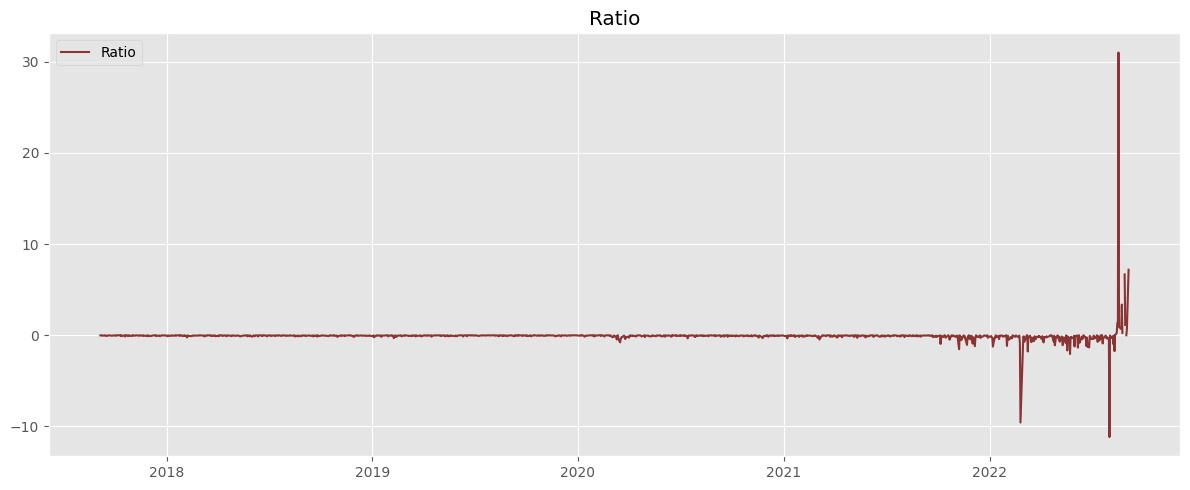

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=100)
plt.title('Ratio')
ax.plot(data['ratio'], label='Ratio', color='#8b3434')
plt.legend()
plt.tight_layout()
plt.show();

## Gráfico de retorno médio por dias do mês

* Podemos ver uma boa quantidade de dias com retorno negativo.

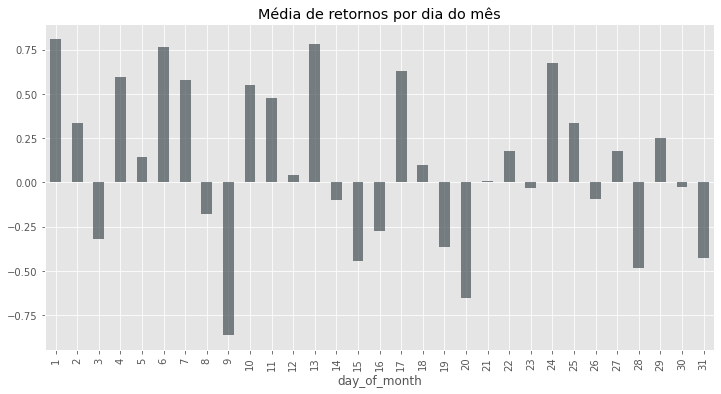

In [10]:
grouped_by_day = data.groupby('day_of_month')['returns'].mean()
grouped_by_day.plot.bar(title="Média de retornos por dia do mês", figsize=(12,6), color='#455054', alpha=0.7);

## Gráfico de retorno médio por dias da semana

* Podemos ver que somente a quinta-feira mostrou um resultado negativo ao longo dos 5 anos.

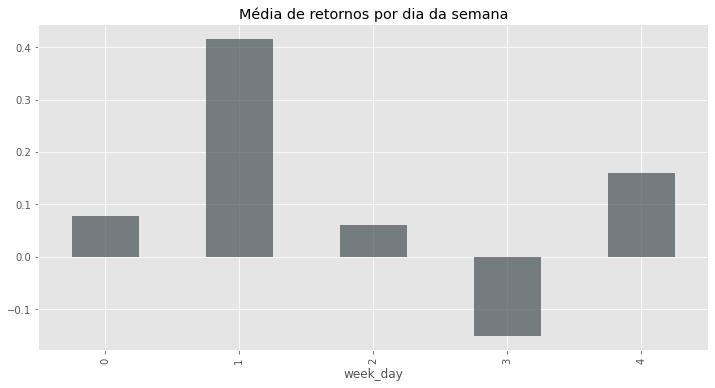

In [11]:
grouped_by_week_day = data.groupby('week_day')['returns'].mean()
grouped_by_week_day.plot.bar(title="Média de retornos por dia da semana", figsize=(12,6), color='#455054', alpha=0.7);

## Gráfico de retorno médio por ano

* Podemos observar que ao longo dos anos tivemos retornos positivos, somente em **2022** os resultados foram negativos.

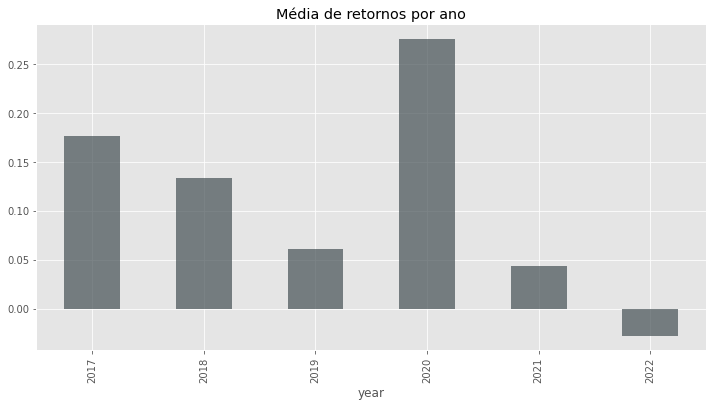

In [12]:
grouped_by_year = data.groupby('year')['returns'].mean()
grouped_by_year.plot.bar(title="Média de retornos por ano", figsize=(12,6), color='#455054', alpha=0.7);

# Fazendo filtro com o ratio e média móvel

* Filtro 1: o ratio precisa estar abaixo da sua mediana;
* Filtro 2: o fechamento precisa estar acima da média móvel exponencial.

In [13]:
filtro1 = (data['ratio'] < data['ratio'].median())
filtro2 = (data['Adj Close'] > data['ema'])

data_filt = data[filtro1 & filtro2]
print(data_filt.shape)

(397, 15)


## Gráfico de retorno médio por dias do mês (filtrado)

* Podemos ver, que na média, todos os dias do mês foram tiveram retorno positivo.

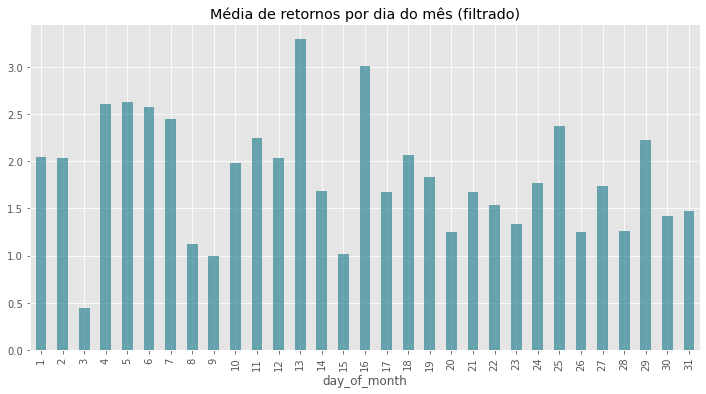

In [14]:
grouped_by_day_filt = data_filt.groupby('day_of_month')['returns'].mean()
grouped_by_day_filt.plot.bar(title="Média de retornos por dia do mês (filtrado)", figsize=(12,6), color='#308695', alpha=0.7);

## Gráfico de retorno médio por dias da semana (filtrado)

* Podemos ver que  ao longo dos 5 anos tivemos todos os dias da semana com retornos positivos.

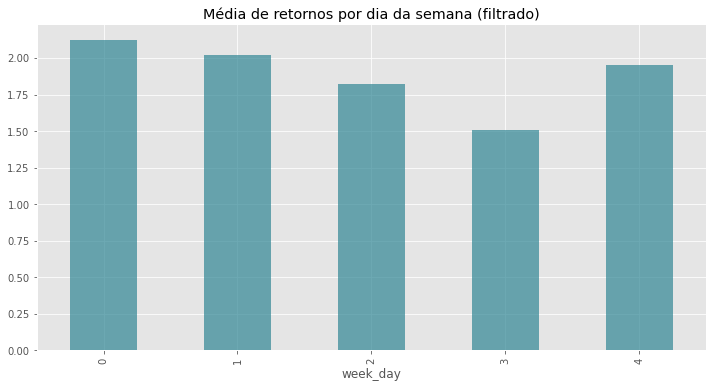

In [15]:
grouped_by_week_day_filt = data_filt.groupby('week_day')['returns'].mean()
grouped_by_week_day_filt.plot.bar(title="Média de retornos por dia da semana (filtrado)", figsize=(12,6), color='#308695', alpha=0.7);

## Gráfico de retorno médio por ano (filtrado)

* Podemos observar que ao longo dos anos tivemos retornos positivos, inclusive em **2022**.

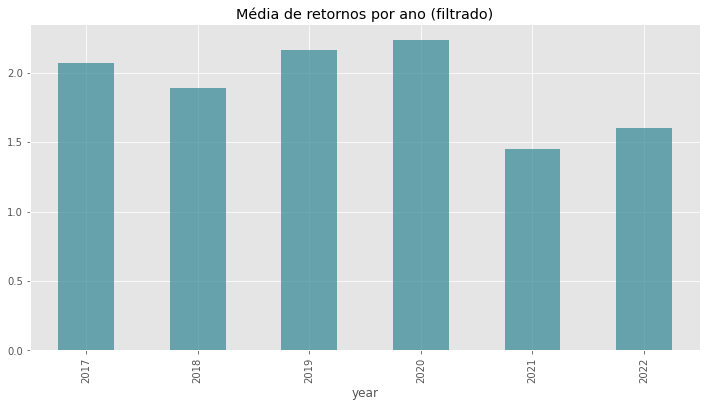

In [16]:
grouped_by_year_filt = data_filt.groupby('year')['returns'].mean()
grouped_by_year_filt.plot.bar(title="Média de retornos por ano (filtrado)", figsize=(12,6), color='#308695', alpha=0.7);

# Gráficos com acumulado de drawdown

* Nesse gráfico foi gerado o retorno acumulado e o drawdown, com destaque para o retorno alto com baixo drawdown.

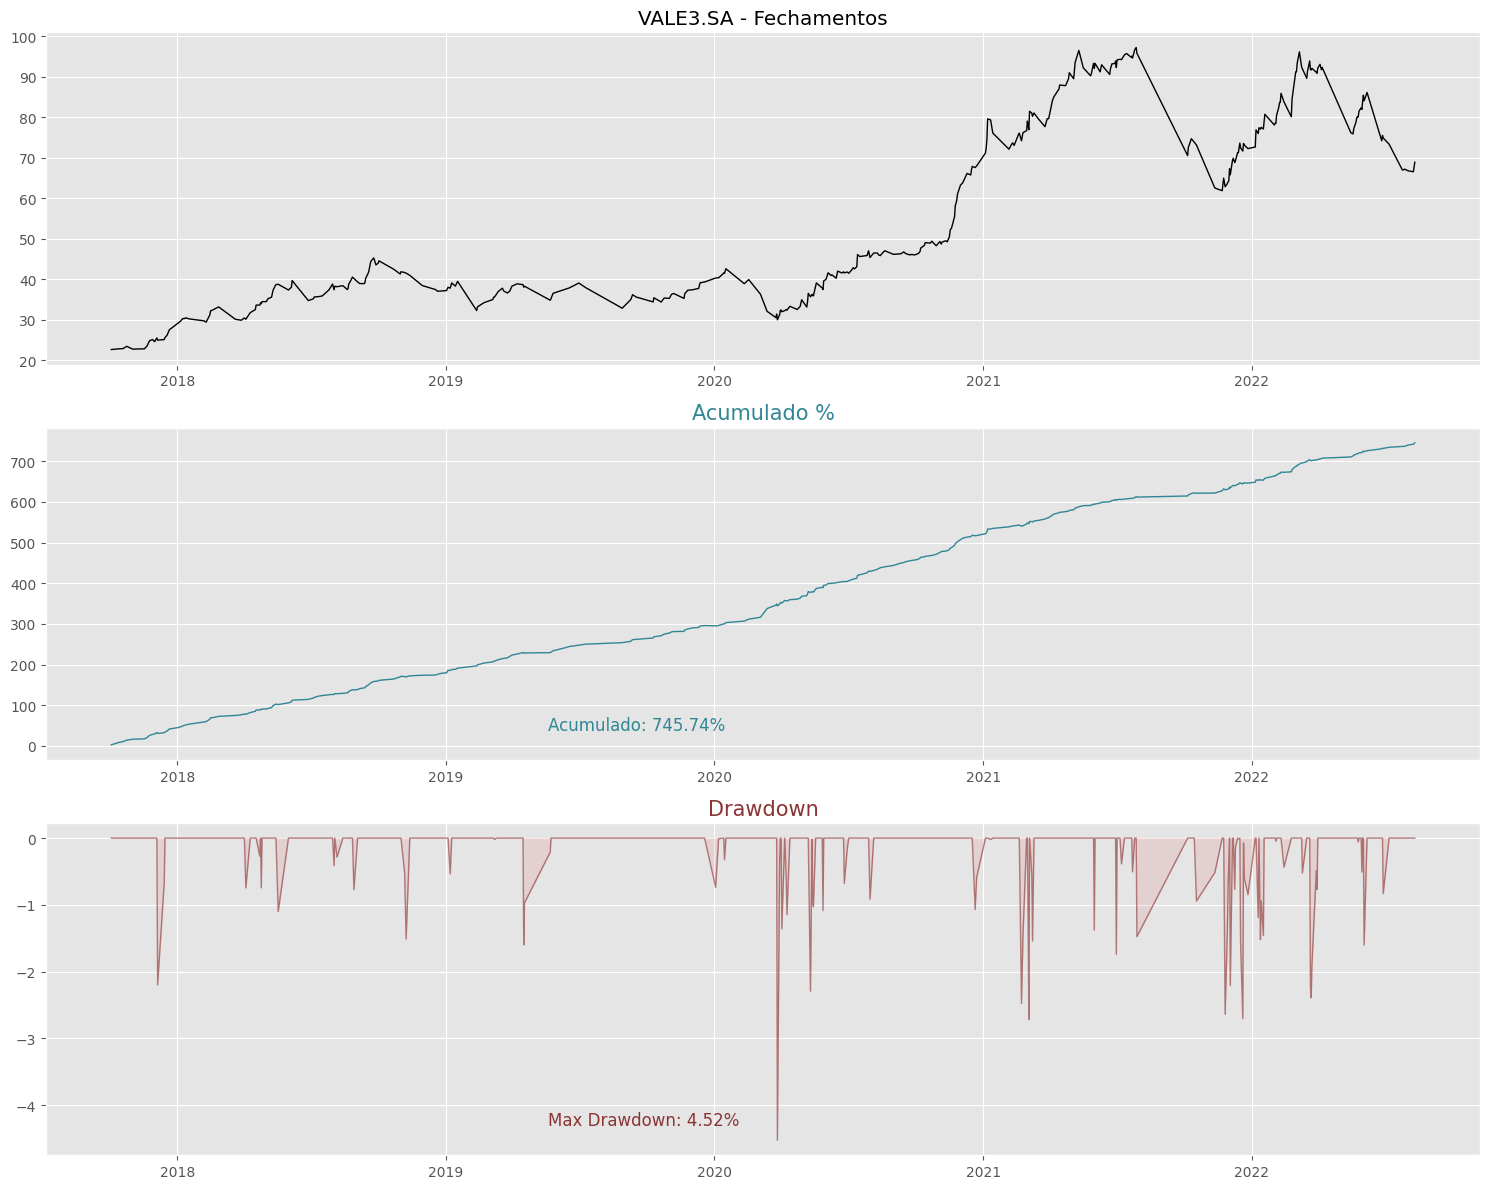

In [17]:
drawdown = ta.drawdown(data_filt['returns'].cumsum())['DD']*-1
max_drawdown = ta.max_drawdown(data_filt['returns'].cumsum())
last_acc = data_filt['returns'].cumsum()[-1]

fig, ax = plt.subplots(3, 1, figsize=(15, 12), dpi=100)

ax[0].set_title(f'{ativo} - Fechamentos')
ax[0].plot(data_filt['Adj Close'], color='black', lw=1)

ax[1].set_title('Acumulado %', fontdict={'size':15, 'color':'#308695'})
ax[1].plot(data_filt['returns'].cumsum(), color='#308695', lw=1)
ax[1].text(0.35, 0.09, f'Acumulado: {round(last_acc, 2)}%',
           fontdict={'size':12, 'color':'#308695'}, transform=ax[1].transAxes)

ax[2].set_title('Drawdown', fontdict={'size':15, 'color':'#8b3434'})
ax[2].plot(drawdown, color='#8b3434', lw=1, alpha=0.6)
ax[2].fill_between(drawdown.index, drawdown, 0, color='tab:red', alpha=0.1)
ax[2].text(0.35, 0.09, f'Max Drawdown: {round(max_drawdown, 2)}%',
           fontdict={'size':12, 'color':'#8b3434'}, transform=ax[2].transAxes)

plt.tight_layout()
plt.show();

In [18]:
def autolabel(axis, rects, color1, color2):
    for rect in rects:
        height = rect.get_height()
        space = 0
        color = color1
        if height < 0:
            color= color2
        
        axis.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, height),  
                    textcoords="offset points", size=8.5,color=color,
                    ha='center', va='bottom')

# Gráficos comparativos da estratégia com filtro e sem filtro

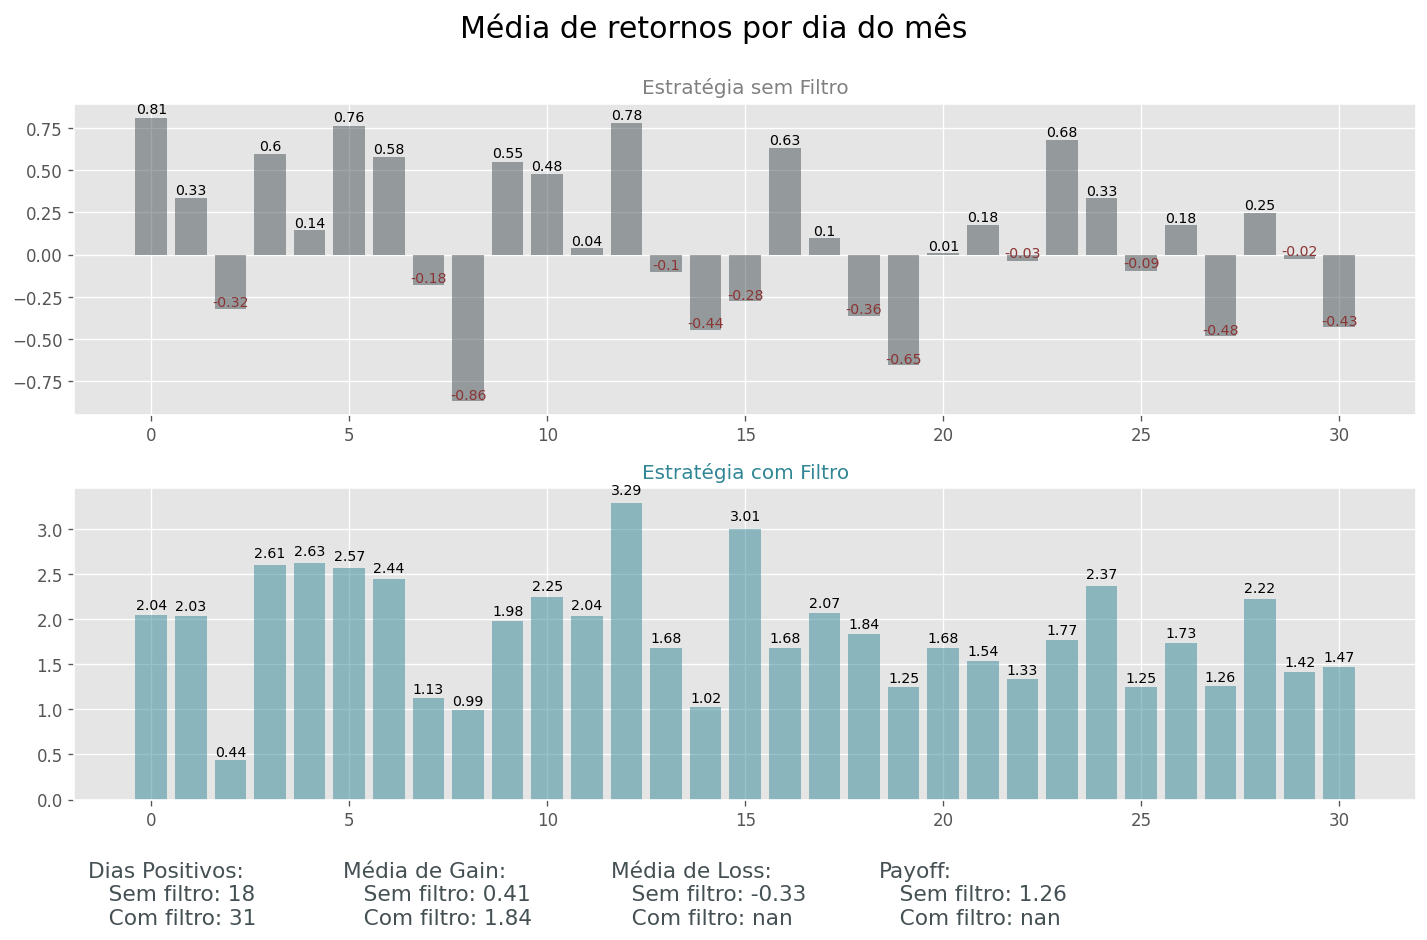

In [19]:
fig, ax = plt.subplots(2, 1, dpi=120, figsize=(12, 8))

fig.suptitle('Média de retornos por dia do mês', fontsize=18)

ax[0].set_title(f'\n\n\nEstratégia sem Filtro', fontdict={'size':12, 'color':'gray'})
rr1 = ax[0].bar(range(len(grouped_by_day)), grouped_by_day, color='#455054', alpha=0.5, label='Sem filtro')
autolabel(ax[0], rr1, 'black', '#8b3434')

ax[1].set_title(f'Estratégia com Filtro', fontdict={'size':12, 'color':'#308695'})
rr2 = ax[1].bar(range(len(grouped_by_day_filt)), grouped_by_day_filt, color='#308695', alpha=0.5, label='Com filtro')
autolabel(ax[1], rr2, 'black', '#8b3434')

text = 'Dias Positivos:'
text += f'\n   Sem filtro: {len(grouped_by_day[grouped_by_day > 0])}'
text += f'\n   Com filtro: {len(grouped_by_day_filt[grouped_by_day_filt > 0])}'
ax[1].text(0.01, -0.4, text, fontdict={'size':13, 'color':'#455054'}, transform=ax[1].transAxes)

text = 'Média de Gain:'
text += f'\n   Sem filtro: {round(grouped_by_day[grouped_by_day > 0].mean(), 2)}'
text += f'\n   Com filtro: {round(grouped_by_day_filt[grouped_by_day_filt > 0].mean(), 2)}'
ax[1].text(0.2, -0.4, text, fontdict={'size':13, 'color':'#455054'}, transform=ax[1].transAxes)

text = 'Média de Loss:'
text += f'\n   Sem filtro: {round(grouped_by_day[grouped_by_day < 0].mean(), 2)}'
text += f'\n   Com filtro: {round(grouped_by_day_filt[grouped_by_day_filt < 0].mean(), 2)}'
ax[1].text(0.4, -0.4, text, fontdict={'size':13, 'color':'#455054'}, transform=ax[1].transAxes)

text = 'Payoff:'
text += f'\n   Sem filtro: {round(grouped_by_day[grouped_by_day > 0].mean() / abs(grouped_by_day[grouped_by_day < 0].mean()), 2)}'
text += f'\n   Com filtro: {round(grouped_by_day_filt[grouped_by_day_filt > 0].mean()/grouped_by_day_filt[grouped_by_day_filt < 0].mean(), 2)}'
ax[1].text(0.6, -0.4, text, fontdict={'size':13, 'color':'#455054'}, transform=ax[1].transAxes)


plt.tight_layout()
plt.show();

Podemos observar que houve uma melhora significativa nos dias positivos ao aplicarmos o filtro, com média de trades positivos muito acima para os dias sem filtro.

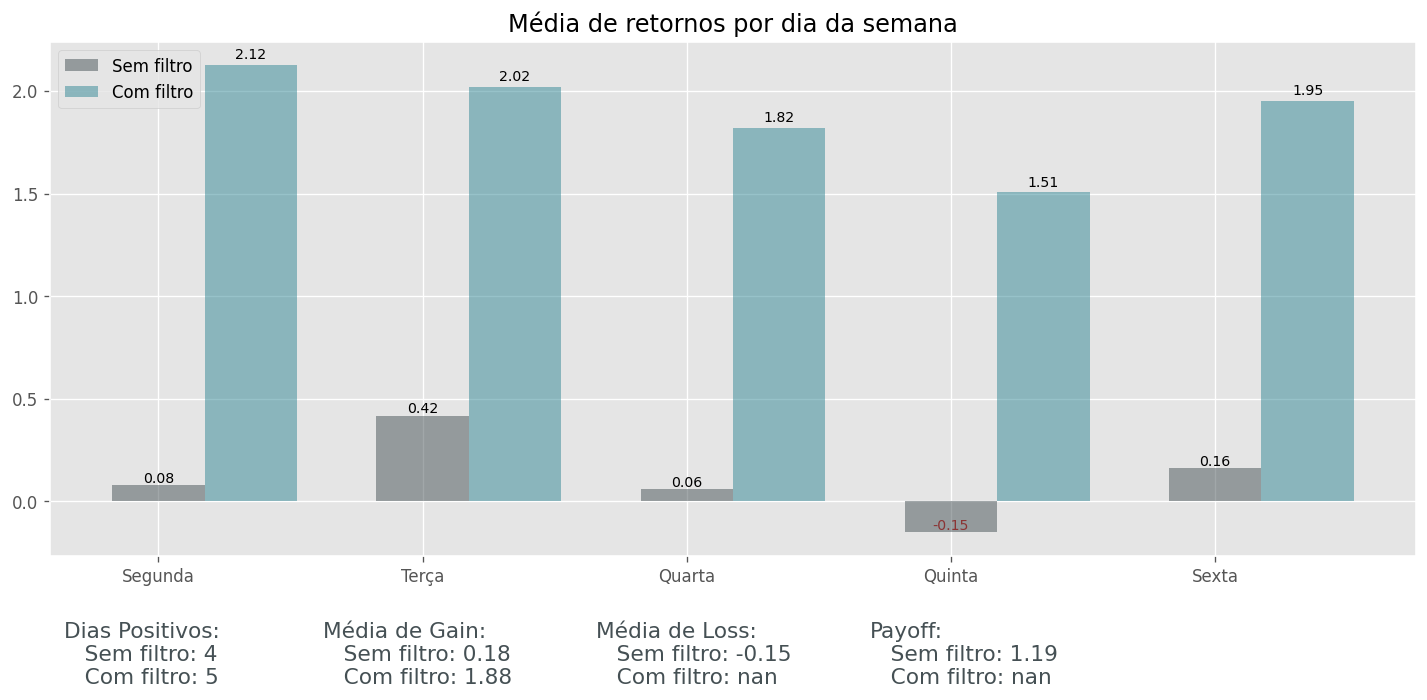

In [20]:
fig, ax = plt.subplots(1, 1, dpi=120, figsize=(12, 6))

plt.title('Média de retornos por dia da semana')

width = 0.35

bar1 = ax.bar(np.arange(len(grouped_by_week_day)), grouped_by_week_day,
                color='#455054', alpha=0.5, label='Sem filtro', width=width)
autolabel(ax, bar1, 'black', '#8b3434')

bar2 = ax.bar(np.arange(len(grouped_by_week_day_filt))+width, grouped_by_week_day_filt,
                color='#308695', alpha=0.5, label='Com filtro', width=width)
autolabel(ax, bar2, 'black', '#8b3434')

ax.legend()
ax.set_xticks(np.arange(len(grouped_by_week_day_filt)))
ax.set_xticklabels(['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'])

text = 'Dias Positivos:'
text += f'\n   Sem filtro: {len(grouped_by_week_day[grouped_by_week_day > 0])}'
text += f'\n   Com filtro: {len(grouped_by_week_day_filt[grouped_by_week_day_filt > 0])}'
ax.text(0.01, -0.25, text, fontdict={'size':13, 'color':'#455054'}, transform=ax.transAxes)

text = 'Média de Gain:'
text += f'\n   Sem filtro: {round(grouped_by_week_day[grouped_by_week_day > 0].mean(), 2)}'
text += f'\n   Com filtro: {round(grouped_by_week_day_filt[grouped_by_week_day_filt > 0].mean(), 2)}'
ax.text(0.2, -0.25, text, fontdict={'size':13, 'color':'#455054'}, transform=ax.transAxes)

text = 'Média de Loss:'
text += f'\n   Sem filtro: {round(grouped_by_week_day[grouped_by_week_day < 0].mean(), 2)}'
text += f'\n   Com filtro: {round(grouped_by_week_day_filt[grouped_by_week_day_filt < 0].mean(), 2)}'
ax.text(0.4, -0.25, text, fontdict={'size':13, 'color':'#455054'}, transform=ax.transAxes)

text = 'Payoff:'
text += f'\n   Sem filtro: {round(grouped_by_week_day[grouped_by_week_day > 0].mean() / abs(grouped_by_week_day[grouped_by_week_day< 0].mean()), 2)}'
text += f'\n   Com filtro: {round(grouped_by_week_day_filt[grouped_by_week_day_filt > 0].mean()/grouped_by_week_day_filt[grouped_by_week_day_filt < 0].mean(), 2)}'
ax.text(0.6, -0.25, text, fontdict={'size':13, 'color':'#455054'}, transform=ax.transAxes)


plt.tight_layout()
plt.show();

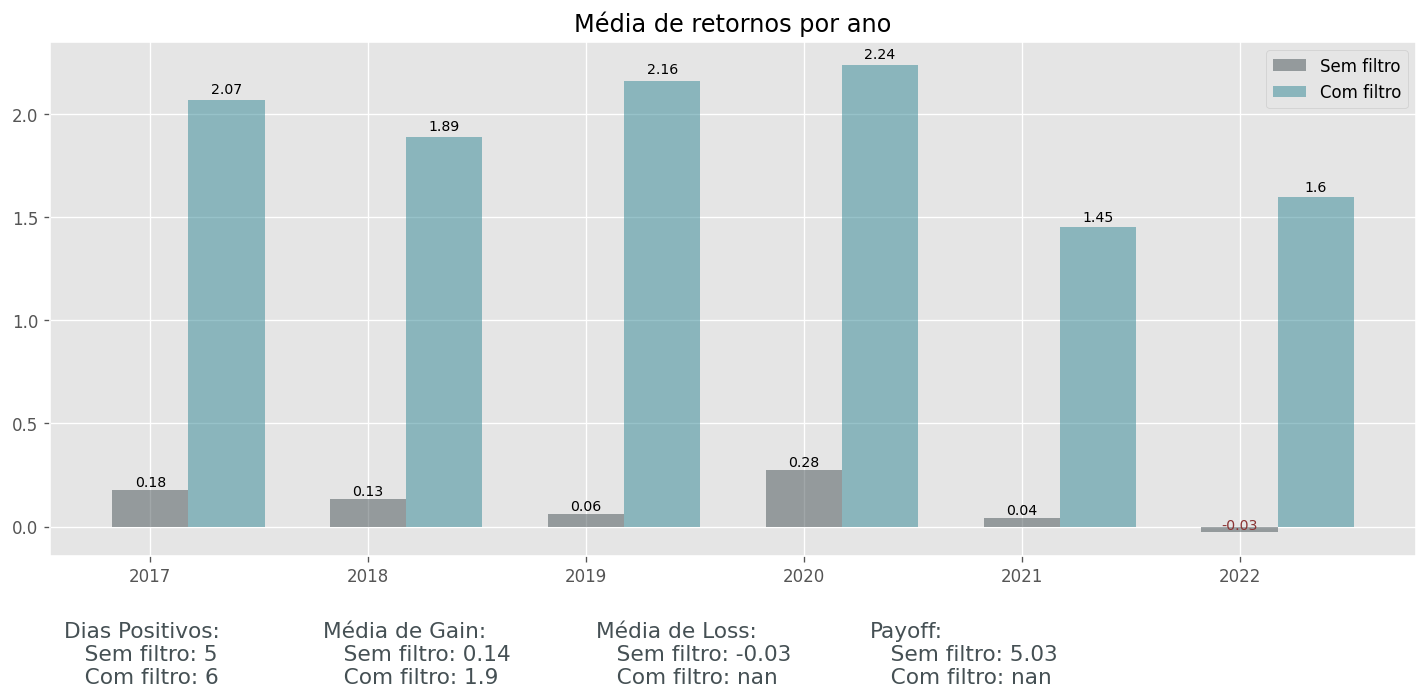

In [21]:
fig, ax = plt.subplots(1, 1, dpi=120, figsize=(12, 6))

plt.title('Média de retornos por ano')

width = 0.35

bar1 = ax.bar(np.arange(len(grouped_by_year)), grouped_by_year,
                color='#455054', alpha=0.5, label='Sem filtro', width=width)
autolabel(ax, bar1, 'black', '#8b3434')

bar2 = ax.bar(np.arange(len(grouped_by_year_filt))+width, grouped_by_year_filt,
                color='#308695', alpha=0.5, label='Com filtro', width=width)
autolabel(ax, bar2, 'black', '#8b3434')

ax.legend()
ax.set_xticks(np.arange(len(grouped_by_year)))
ax.set_xticklabels(list(grouped_by_year.index))

text = 'Dias Positivos:'
text += f'\n   Sem filtro: {len(grouped_by_year[grouped_by_year > 0])}'
text += f'\n   Com filtro: {len(grouped_by_year_filt[grouped_by_year_filt > 0])}'
ax.text(0.01, -0.25, text, fontdict={'size':13, 'color':'#455054'}, transform=ax.transAxes)

text = 'Média de Gain:'
text += f'\n   Sem filtro: {round(grouped_by_year[grouped_by_year > 0].mean(), 2)}'
text += f'\n   Com filtro: {round(grouped_by_year_filt[grouped_by_year_filt > 0].mean(), 2)}'
ax.text(0.2, -0.25, text, fontdict={'size':13, 'color':'#455054'}, transform=ax.transAxes)

text = 'Média de Loss:'
text += f'\n   Sem filtro: {round(grouped_by_year[grouped_by_year < 0].mean(), 2)}'
text += f'\n   Com filtro: {round(grouped_by_year_filt[grouped_by_year_filt < 0].mean(), 2)}'
ax.text(0.4, -0.25, text, fontdict={'size':13, 'color':'#455054'}, transform=ax.transAxes)

text = 'Payoff:'
text += f'\n   Sem filtro: {round(grouped_by_year[grouped_by_year > 0].mean() / abs(grouped_by_year[grouped_by_year< 0].mean()), 2)}'
text += f'\n   Com filtro: {round(grouped_by_year_filt[grouped_by_year_filt > 0].mean()/grouped_by_year_filt[grouped_by_year_filt < 0].mean(), 2)}'
ax.text(0.6, -0.25, text, fontdict={'size':13, 'color':'#455054'}, transform=ax.transAxes)


plt.tight_layout()
plt.show();